In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e26/train.csv", index_col='id')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e26/test.csv", index_col='id')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import log_loss, make_scorer
import xgboost as xgb
import optuna

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def days_to_years(df, columns):
    return df[columns].apply(lambda x: x / 365.25)


def get_cv_score(X, y, params=None):    
    if params:
        estimator = xgb.XGBClassifier(**params)
    else:
        estimator = xgb.XGBClassifier(tree_method='hist', device='cuda')
        
    sampler = StratifiedKFold(n_splits=5)
    scorer = make_scorer(log_loss, greater_is_better=True, needs_proba=True)
    return cross_val_score(estimator, X, y, cv=sampler, scoring=scorer)


def tuning_xgb(X, y):
    
    def objective(trial):
        xgb_params = {
            'tree_method':'hist',
            'device': 'cuda',
            'lambda': trial.suggest_float('lambda', 0.01, 10.0),
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_weight": trial.suggest_int("min_child_weight", 0, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
            "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.1),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.1, 1),
#             "reg_alpha": trial.suggest_float('reg_alpha', 0, 1),
        }
        
        scores = get_cv_score(X, y, params=xgb_params)
        return scores.mean()
        
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    return study


def make_submission(model, X):
#     test_df[['N_Days', 'Age']] = days_to_years(test_df, ['N_Days', 'Age'])
#     test_num_features = test_df.select_dtypes(np.number)
#     test_cat_features = test_df.select_dtypes('object')

#     encoded_features = pd.concat([test_num_features,
#                                   pd.get_dummies(test_cat_features, dtype='int32')], axis=1)
    y_pred = model.predict_proba(X)
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = ['Status_C', 'Status_CL','Status_D']

    submission_df = pd.DataFrame()
    submission_df = y_pred  
    submission_df['id'] = X.index
    submission_df['id'] = submission_df['id'].apply(lambda x : int(x))

    submission_df.to_csv('submission.csv', index= False)

# Transform days to years

In [5]:
train_df[['N_Days', 'Age']] = days_to_years(train_df, ['N_Days', 'Age'])
test_df[['N_Days', 'Age']] = days_to_years(test_df, ['N_Days', 'Age'])

# Baseline model
XGB + OHE

In [6]:
train_data = train_df.copy()
train_labels = train_data['Status'].map({'C':0, 'CL':1, 'D':2})
train_data.drop('Status', axis=1, inplace=True)

train_num_cols = train_data.select_dtypes(np.number)
train_cat_cols = train_data.select_dtypes('object')

train_data = pd.concat([train_num_cols,
                              pd.get_dummies(train_cat_cols, dtype='int32')], axis=1)


get_cv_score(train_data, train_labels).mean()

# tuned = tuning_xgb(train_data, train_labels)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:44:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.513896903684446

In [7]:
# tuned.best_params
p = {'lambda': 8.366432100590675,
 'alpha': 0.012595143782964113,
 'n_estimators': 456,
 'max_depth': 11,
 'min_child_weight': 1,
 'learning_rate': 0.057251606328022064,
 'subsample': 0.8,
 'colsample_bytree': 0.11768228992035056}

# get_cv_score(train_data, train_labels, p).mean()

# {'lambda': 1.9621386829408207,
#  'alpha': 2.705285419018762,
#  'max_depth': 12,
#  'min_child_weight': 0,
#  'learning_rate': 0.2344680688504997,
#  'subsample': 0.9,
#  'colsample_bytree': 0.13499510903584383}

In [8]:
test_data = test_df.copy()

test_num_cols = test_data.select_dtypes(np.number)
test_cat_cols = test_data.select_dtypes('object')

test_data = pd.concat([test_num_cols,
                              pd.get_dummies(test_cat_cols, dtype='int32')], axis=1)

model = xgb.XGBClassifier(**p)
model.fit(train_data, train_labels)
# make_submission(model, test_data)

XGBClassifier(alpha=0.012595143782964113, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.11768228992035056, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=8.366432100590675,
              learning_rate=0.057251606328022064, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=456, n_jobs=None, ...)

# Outlier treatment model

In [9]:
train_data = train_df.copy()
train_labels = train_data['Status'].map({'C':0, 'CL':1, 'D':2})
train_data.drop('Status', axis=1, inplace=True)

train_num_cols = train_data.select_dtypes(np.number)
train_cat_cols = train_data.select_dtypes('object')

upper_bounds = train_num_cols.quantile(0.99)

for i, col in enumerate(train_num_cols):
    for j, val_j in enumerate(train_num_cols[col]):
        if val_j >= upper_bounds[i]:
            train_num_cols.iloc[j, i] = upper_bounds[i]

            
train_data = pd.concat([train_num_cols, pd.get_dummies(train_cat_cols.iloc[:,:-1], dtype='int32')], axis=1)
get_cv_score(train_data, train_labels).mean()

/tmp/ipykernel_26/1687095230.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if val_j >= upper_bounds[i]:
/tmp/ipykernel_26/1687095230.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_num_cols.iloc[j, i] = upper_bounds[i]


0.5230410225760522

## Polynomial features model

In [10]:
train_data = train_df.copy()
train_labels = train_data['Status'].map({'C':0, 'CL':1, 'D':2})
train_data.drop('Status', axis=1, inplace=True)

train_num_cols = train_data.select_dtypes(np.number)
train_cat_cols = train_data.select_dtypes('object')

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
data_poly = pd.DataFrame(poly.fit_transform(train_num_cols))

train_data = pd.concat([data_poly, pd.get_dummies(train_cat_cols.iloc[:,:-1], dtype='int32')], axis=1)

get_cv_score(train_data, train_labels).mean()

0.5728935743930086

## Features created model

In [11]:
train_data = train_df.copy()
train_labels = train_data['Status'].map({'C':0, 'CL':1, 'D':2})
train_data.drop('Status', axis=1, inplace=True)

train_num_cols = train_data.select_dtypes(np.number)
train_cat_cols = train_data.select_dtypes('object')

train_data = pd.concat([train_num_cols,
                              pd.get_dummies(train_cat_cols.iloc[:,:-1], dtype='int32')], axis=1)

train_data['AgeOver60'] = (train_data['Age'] > 60).astype('int32')
train_data['DaysOver5'] = (train_data['N_Days'] > 5).astype('int32')
train_data['PlateletsOver250'] = (train_data['Platelets'] > 250).astype('int32')
train_data['BilirubinOver5'] = (train_data['Bilirubin'] > 3).astype('int32')
train_data['bico'] = train_data['Bilirubin'] + train_data['Copper']
# train_data['bicho'] = train_data['Bilirubin'] + train_data['Cholesterol']


# tuned = tuning_xgb(train_data, train_labels)

In [12]:

p = {'lambda': 5.120381244878516,
 'alpha': 2.877378128235514,
 'n_estimators': 216,
 'max_depth': 5,
 'min_child_weight': 0,
 'learning_rate': 0.24829456977314834,
 'subsample': 0.8,
 'colsample_bytree': 0.10415029754015104}

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, stratify=train_labels,test_size=0.2)

model = xgb.XGBClassifier(**p)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='mlogloss')

[0]	validation_0-mlogloss:1.00431	validation_1-mlogloss:1.00447
[1]	validation_0-mlogloss:0.90514	validation_1-mlogloss:0.90676
[2]	validation_0-mlogloss:0.81842	validation_1-mlogloss:0.82090
[3]	validation_0-mlogloss:0.74418	validation_1-mlogloss:0.74827
[4]	validation_0-mlogloss:0.70010	validation_1-mlogloss:0.70395
[5]	validation_0-mlogloss:0.66153	validation_1-mlogloss:0.66465
[6]	validation_0-mlogloss:0.62615	validation_1-mlogloss:0.62888
[7]	validation_0-mlogloss:0.60087	validation_1-mlogloss:0.60432
[8]	validation_0-mlogloss:0.58155	validation_1-mlogloss:0.58617
[9]	validation_0-mlogloss:0.56813	validation_1-mlogloss:0.57201
[10]	validation_0-mlogloss:0.55556	validation_1-mlogloss:0.55884
[11]	validation_0-mlogloss:0.54449	validation_1-mlogloss:0.54809
[12]	validation_0-mlogloss:0.53244	validation_1-mlogloss:0.53699
[13]	validation_0-mlogloss:0.52299	validation_1-mlogloss:0.52805
[14]	validation_0-mlogloss:0.51473	validation_1-mlogloss:0.52020
[15]	validation_0-mlogloss:0.50807	

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-mlogloss:0.44620	validation_1-mlogloss:0.46408
[35]	validation_0-mlogloss:0.44459	validation_1-mlogloss:0.46298
[36]	validation_0-mlogloss:0.44048	validation_1-mlogloss:0.45975
[37]	validation_0-mlogloss:0.43678	validation_1-mlogloss:0.45661
[38]	validation_0-mlogloss:0.43582	validation_1-mlogloss:0.45607
[39]	validation_0-mlogloss:0.43365	validation_1-mlogloss:0.45486
[40]	validation_0-mlogloss:0.43099	validation_1-mlogloss:0.45265
[41]	validation_0-mlogloss:0.42881	validation_1-mlogloss:0.45056
[42]	validation_0-mlogloss:0.42787	validation_1-mlogloss:0.44972
[43]	validation_0-mlogloss:0.42733	validation_1-mlogloss:0.44906
[44]	validation_0-mlogloss:0.42621	validation_1-mlogloss:0.44818
[45]	validation_0-mlogloss:0.42553	validation_1-mlogloss:0.44736
[46]	validation_0-mlogloss:0.42173	validation_1-mlogloss:0.44542
[47]	validation_0-mlogloss:0.42143	validation_1-mlogloss:0.44537
[48]	validation_0-mlogloss:0.42102	validation_1-mlogloss:0.44542
[49]	validation_0-mloglos

XGBClassifier(alpha=2.877378128235514, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.10415029754015104, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=5.120381244878516,
              learning_rate=0.24829456977314834, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=216, n_jobs=None, ...)

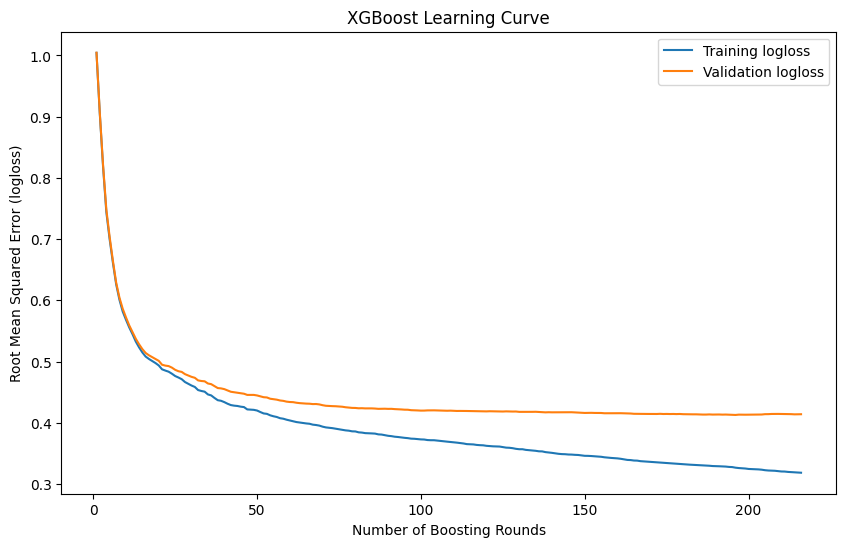

In [13]:
train_loss = model.evals_result_["validation_0"]["mlogloss"]
valid_loss = model.evals_result_["validation_1"]["mlogloss"]

plt.figure(figsize=(10, 6))
plt.plot(range(1, 216 + 1), train_loss, label="Training logloss")
plt.plot(range(1, 216 + 1), valid_loss, label="Validation logloss")
plt.xlabel("Number of Boosting Rounds")
plt.ylabel("Root Mean Squared Error (logloss)")
plt.title("XGBoost Learning Curve")
plt.legend()

In [14]:
{'lambda': 3.590919407267409,
 'alpha': 0.6514611987796886,
 'max_depth': 11,
 'min_child_weight': 6,
 'learning_rate': 0.19178901685829666,
 'subsample': 0.9,
 'colsample_bytree': 0.10532620740742585}

test_data = test_df.copy()
test_num_cols = test_data.select_dtypes(np.number)
test_cat_cols = test_data.select_dtypes('object')

test_data = pd.concat([test_num_cols,
                              pd.get_dummies(test_cat_cols.iloc[:,:-1], dtype='int32')], axis=1)

test_data['AgeOver60'] = (test_data['Age'] > 60).astype('int32')
test_data['DaysOver5'] = (test_data['N_Days'] > 5).astype('int32')
test_data['PlateletsOver250'] = (test_data['Platelets'] > 250).astype('int32')
test_data['BilirubinOver5'] = (test_data['Bilirubin'] > 3).astype('int32')
test_data['bico'] = test_data['Bilirubin'] + test_data['Copper']



model = xgb.XGBClassifier(**p)
model.fit(train_data, train_labels)

make_submission(model, test_data)

# Age binning model

In [15]:
train_data = train_df.copy()
train_labels = train_data['Status'].map({'C':0, 'CL':1, 'D':2})
train_data.drop('Status', axis=1, inplace=True)

train_num_cols = train_data.select_dtypes(np.number)
train_cat_cols = train_data.select_dtypes('object')
bin_cols = pd.get_dummies(pd.cut(train_num_cols['Age'], bins=5, labels=['1','2','3','4','5']), dtype='int32')

train_data = pd.concat([train_num_cols, bin_cols, pd.get_dummies(train_cat_cols, dtype='int32')], axis=1)

get_cv_score(train_data, train_labels).mean()

# train_data


0.5137563987928991